## 직접 고른 이미지로 SRGAN 실험하기
---


In [1]:
import tensorflow as tf
import os
import cv2
import numpy as np


import matplotlib.pyplot as plt
import matplotlib.image as image
import tensorflow_datasets as tfds


from tensorflow.keras import layers, Sequential
from tensorflow.keras import Input, Model

from skimage import data
from tensorflow.python.keras import applications
from tensorflow.keras import losses, metrics, optimizers

## project 1-1.

### 1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.

In [29]:
image_path = os.path.join(os.getenv('HOME'), 'aiffel','super_resolution')
image_path

'/home/ssac27/aiffel/super_resolution'

In [10]:
img = image.imread(image_path+'/Autumn_day_in_the_forest_(1889)_ MutualArt.jpeg')

### 2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다. **cv2.resize()**를 사용해 봅시다.

In [11]:
img.shape  # (세로, 가로, RGB)

(3483, 2248, 3)

(870, 562, 3)


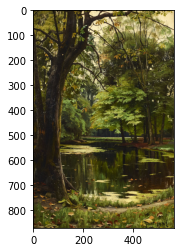

In [14]:
import cv2
# 이미지를 특정 크기로 줄이고 다시 늘리는 과정을 함수로 정의합니다.
def img_downsample(image, n):
    downsample = cv2.resize(
        image,
        dsize=(image.shape[1]//n, image.shape[0]//n), # dsize() (가로 픽셀 수, 세로 픽셀 수) 
        interpolation=cv2.INTER_CUBIC
    )                 # 세로가 0번, 가로가 1번이다.
    return downsample

down4_img = img_downsample(img, 4) # 1/4로 줄이기

print(down4_img.shape)  # 이미지가 1/4 크기로 줄어들었다. 
plt.imshow(down4_img)

### 3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 **apply_srgan** 함수를 사용하면 쉽습니다.

SRGAN을 학습 시켜서 사용하려면 많은 시간을 요구로 합니다.

따라서, 이미 학습 완료된 Generator인 srgan_G.h5 파일을 다운로드받아 코드를 실행해 학습 완료된 모델을 불러옵니다.


In [6]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file, compile=False) 
# compile=False를 하지 않을 경우 WARNING이 발생한다. 
# 관련 내용 :
# https://stackoverflow.com/questions/53295570/userwarning-no-training-configuration-found-in-save-file-the-model-was-not-c

In [7]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

srgan_hr = apply_srgan(down4_img)

### 4. 2.의 이미지에 **bicubic interpolation**을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 **cv2.resize()**를 사용해 봅시다.

(3483, 2248, 3)


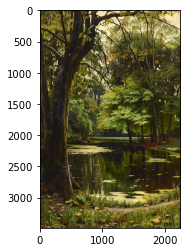

In [8]:
def img_upsample(image, n) :
    upsample = cv2.resize(
        image,
        dsize=(img.shape[1], img.shape[0]),   # 1/4로 줄이기 전의 원본 이미지 크기
        interpolation=cv2.INTER_CUBIC
)
    return upsample
bicubic_hr = img_upsample(down4_img, 4) # 이미지 크기를 4배로 늘립니다.
print(bicubic_hr.shape)
plt.imshow(bicubic_hr)

### 5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.

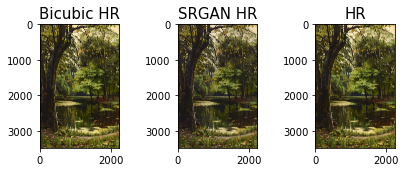

In [26]:
# 타이틀 별 이미지를 가지고 옵니다.
images = [ bicubic_hr, srgan_hr, img ]
titles = ["Bicubic HR", "SRGAN HR", "HR"]

# 이미지 제목을 포함하여 시각화 합니다. 
plt.figure(figsize=(7,5))
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] , fontsize=15)

이미지 전체를 시각화했을 때 세부적인 선명함이 눈에 띄지 않았기 때문에, 일부 영역을 잘라내어 시각적으로 비교해보겠습니다.  
3개 이미지(bicubic interpolation의 결과, SRGAN의 결과, 원래 고해상도 이미지)를 나란히 시각화합니다.

In [12]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=300, y=300):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

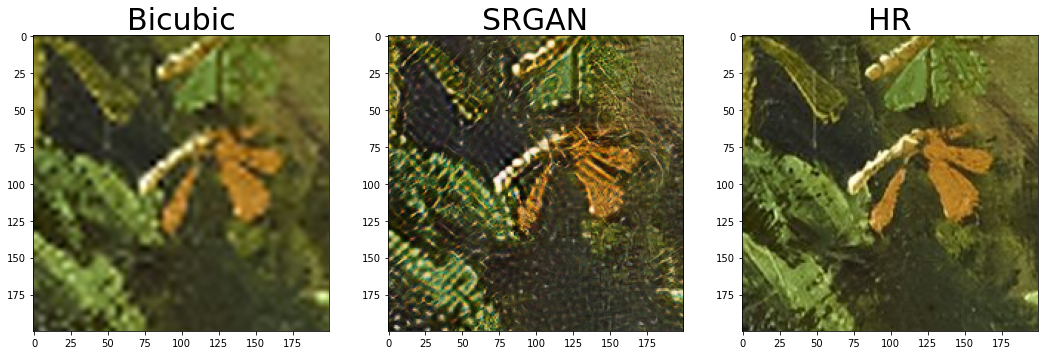

In [13]:
left_tops = [(1500,700)] *3

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 200, 200)
    img2 = crop(srgan_hr , left_top, 200, 200)
    img3 = crop(img, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"]

plt.figure(figsize=(18,18))
for i in range(3):
    plt.subplot(1,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

Bicubic -> SRGAN -> HR 순으로 선명한 것을 확인할 수 있습니다.

## 6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)


DIV2K 데이터셋으로 모델을 학습한 후 Super Resolution을 하겠습니다.

#### DIV2K 데이터셋으로 모델 학습하기

In [14]:
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)
def preprocessing(lr, hr):
    hr = tf.cast(hr, tf.float32) /255.
        
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr_patch = tf.image.random_crop(hr, size=[96,96,3])
        
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄입니다
    # 이렇게 만든 저해상도 이미지를 SRGAN의 입력으로 사용합니다.
    lr_patch = tf.image.resize(hr_patch, [96//4, 96//4], "bicubic")
    return lr_patch, hr_patch

train = train.map(preprocessing).shuffle(buffer_size=10).repeat().batch(8)
valid = valid.map(preprocessing).repeat().batch(8)

### SRGAN 구현하기



##### [1]. Generator 구현

In [15]:
# 그림의 파란색 블록을 정의합니다.
def gene_base_block(x):
    out = layers.Conv2D(64, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.PReLU(shared_axes=[1,2])(out)
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.Add()([x, out])

# 그림의 뒤쪽 연두색 블록을 정의합니다.
def upsample_block(x):
    out = layers.Conv2D(256, 3, 1, "same")(x)
    # 그림의 PixelShuffler 라고 쓰여진 부분을 아래와 같이 구현합니다.
    out = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))(out)
    return layers.PReLU(shared_axes=[1,2])(out)
    
# 전체 Generator를 정의합니다.
def get_generator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 9, 1, "same")(inputs)
    out = residual = layers.PReLU(shared_axes=[1,2])(out)
    
    for _ in range(5):
        out = gene_base_block(out)
    
    out = layers.Conv2D(64, 3, 1, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.Add()([residual, out])
    
    for _ in range(2):
        out = upsample_block(out)
        
    out = layers.Conv2D(3, 9, 1, "same", activation="tanh")(out)

    return Model(inputs, out)



#### [2]. Discriminator 구현

In [16]:
# 그림의 파란색 블록을 정의합니다.
def disc_base_block(x, n_filters=128):
    out = layers.Conv2D(n_filters, 3, 1, "same")(x)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(n_filters, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    return layers.LeakyReLU()(out)

# 전체 Discriminator 정의합니다.
def get_discriminator(input_shape=(None, None, 3)):
    inputs = Input(input_shape)
    
    out = layers.Conv2D(64, 3, 1, "same")(inputs)
    out = layers.LeakyReLU()(out)
    out = layers.Conv2D(64, 3, 2, "same")(out)
    out = layers.BatchNormalization()(out)
    out = layers.LeakyReLU()(out)
    
    for n_filters in [128, 256, 512]:
        out = disc_base_block(out, n_filters)
    
    out = layers.Dense(1024)(out)
    out = layers.LeakyReLU()(out)
    out = layers.Dense(1, activation="sigmoid")(out)
    return Model(inputs, out)

SRGAN은 VGG19를 이용해 content loss를 계산합니다. Tensorflow는 이미지넷 데이터로부터 잘 학습된 VGG19를 제공하고 있으며 이를 이용해 보겠습니다.

In [17]:
from tensorflow.python.keras import applications
def get_feature_extractor(input_shape=(None, None, 3)):
    vgg = applications.vgg19.VGG19(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    # 아래 vgg.layers[20]은 vgg 내의 마지막 convolutional layer 입니다.
    return Model(vgg.input, vgg.layers[20].output)

### SRGAN 학습하기
---
이제부터는 앞에서 정의한 신경망들을 이용해 SRGAN을 학습해 보겠습니다. 이전에 SRCNN과 마찬가지로 학습에 꽤나 오랜 시간이 소요되므로 SRGAN의 학습을 처음부터 전부 진행하진 않겠습니다. 여기서는 200번의 반복만 진행해보겠습니다.
(초반 학습이 불안정하여 Generator의 loss가 증가할 수도 있습니다)

모델의 체크포인트를 지정하여 10 epoch마다 저장하겠습니다.

In [18]:
image_path

'/home/ssac27/aiffel/super_resolution'

#### STEP-200

In [17]:
generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

# 사용할 loss function 및 optimizer 를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()


def get_gene_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def get_disc_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)


@tf.function
def get_content_loss(hr_real, hr_fake):
    hr_real = applications.vgg19.preprocess_input(hr_real)
    hr_fake = applications.vgg19.preprocess_input(hr_fake)
    
    hr_real_feature = vgg(hr_real) / 12.75
    hr_fake_feature = vgg(hr_fake) / 12.75
    return mse(hr_real_feature, hr_fake_feature)


@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)

        
        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)
        
        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)
        
    gene_gradient = gene_tape.gradient(perceptual_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss


gene_losses = metrics.Mean()
disc_losses = metrics.Mean()

for epoch in range(1, 2):
    for i, (lr, hr) in enumerate(train):
#        print("1. step 전")
        g_loss, d_loss = step(lr, hr)
#        print("2. step 후")
#        print("3. loss  시작")
        gene_losses.update_state(g_loss)
#        print("4. gene loss  시작")
        disc_losses.update_state(d_loss)
#        print("5. disc loss  시작")
        # 10회 반복마다 loss를 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")


        if (i+1) == 200: # 200
            break
            
    gene_losses.reset_states()
    disc_losses.reset_states()
    
    


EPOCH[1] - STEP[10] 
Generator_loss:0.0013 
Discriminator_loss:1.3785

EPOCH[1] - STEP[20] 
Generator_loss:0.0018 
Discriminator_loss:0.9599

EPOCH[1] - STEP[30] 
Generator_loss:0.0024 
Discriminator_loss:0.6820

EPOCH[1] - STEP[40] 
Generator_loss:0.0029 
Discriminator_loss:0.5280

EPOCH[1] - STEP[50] 
Generator_loss:0.0034 
Discriminator_loss:0.4275

EPOCH[1] - STEP[60] 
Generator_loss:0.0039 
Discriminator_loss:0.3579

EPOCH[1] - STEP[70] 
Generator_loss:0.0042 
Discriminator_loss:0.3079

EPOCH[1] - STEP[80] 
Generator_loss:0.0043 
Discriminator_loss:0.2706

EPOCH[1] - STEP[90] 
Generator_loss:0.0044 
Discriminator_loss:0.2418

EPOCH[1] - STEP[100] 
Generator_loss:0.0045 
Discriminator_loss:0.2185

EPOCH[1] - STEP[110] 
Generator_loss:0.0048 
Discriminator_loss:0.1990

EPOCH[1] - STEP[120] 
Generator_loss:0.0050 
Discriminator_loss:0.1827

EPOCH[1] - STEP[130] 
Generator_loss:0.0051 
Discriminator_loss:0.1692

EPOCH[1] - STEP[140] 
Generator_loss:0.0053 
Discriminator_loss:0.1575

E

#### STEP-1000

In [19]:
generator = get_generator()
discriminator = get_discriminator()
vgg = get_feature_extractor()

# 사용할 loss function 및 optimizer 를 정의합니다.
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()
gene_opt = optimizers.Adam()
disc_opt = optimizers.Adam()


def get_gene_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

def get_disc_loss(real_out, fake_out):
    return bce(tf.ones_like(real_out), real_out) + bce(tf.zeros_like(fake_out), fake_out)


@tf.function
def get_content_loss(hr_real, hr_fake):
    hr_real = applications.vgg19.preprocess_input(hr_real)
    hr_fake = applications.vgg19.preprocess_input(hr_fake)
    
    hr_real_feature = vgg(hr_real) / 12.75
    hr_fake_feature = vgg(hr_fake) / 12.75
    return mse(hr_real_feature, hr_fake_feature)


@tf.function
def step(lr, hr_real):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        hr_fake = generator(lr, training=True)

        
        real_out = discriminator(hr_real, training=True)
        fake_out = discriminator(hr_fake, training=True)
        
        perceptual_loss = get_content_loss(hr_real, hr_fake) + 1e-3 * get_gene_loss(fake_out)
        discriminator_loss = get_disc_loss(real_out, fake_out)
        
    gene_gradient = gene_tape.gradient(perceptual_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return perceptual_loss, discriminator_loss


gene_losses = metrics.Mean()
disc_losses = metrics.Mean()

for epoch in range(1, 2):
    for i, (lr, hr) in enumerate(train):
#        print("1. step 전")
        g_loss, d_loss = step(lr, hr)
#        print("2. step 후")
#        print("3. loss  시작")
        gene_losses.update_state(g_loss)
#        print("4. gene loss  시작")
        disc_losses.update_state(d_loss)
#        print("5. disc loss  시작")
        # 10회 반복마다 loss를 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \nGenerator_loss:{gene_losses.result():.4f} \nDiscriminator_loss:{disc_losses.result():.4f}", end="\n\n")


        if (i+1) == 200:
            break
            
    gene_losses.reset_states()
    disc_losses.reset_states()
    
    


EPOCH[1] - STEP[10] 
Generator_loss:0.0013 
Discriminator_loss:1.8834

EPOCH[1] - STEP[20] 
Generator_loss:0.0012 
Discriminator_loss:1.5798

EPOCH[1] - STEP[30] 
Generator_loss:0.0013 
Discriminator_loss:1.3318

EPOCH[1] - STEP[40] 
Generator_loss:0.0016 
Discriminator_loss:1.0584

EPOCH[1] - STEP[50] 
Generator_loss:0.0020 
Discriminator_loss:0.8666

EPOCH[1] - STEP[60] 
Generator_loss:0.0024 
Discriminator_loss:0.7312

EPOCH[1] - STEP[70] 
Generator_loss:0.0028 
Discriminator_loss:0.6296

EPOCH[1] - STEP[80] 
Generator_loss:0.0031 
Discriminator_loss:0.5537

EPOCH[1] - STEP[90] 
Generator_loss:0.0034 
Discriminator_loss:0.4937

EPOCH[1] - STEP[100] 
Generator_loss:0.0038 
Discriminator_loss:0.4448

EPOCH[1] - STEP[110] 
Generator_loss:0.0042 
Discriminator_loss:0.4047

EPOCH[1] - STEP[120] 
Generator_loss:0.0044 
Discriminator_loss:0.3713

EPOCH[1] - STEP[130] 
Generator_loss:0.0046 
Discriminator_loss:0.3431

EPOCH[1] - STEP[140] 
Generator_loss:0.0048 
Discriminator_loss:0.3188

E

#### SRGAN step 200번 반복 

위에서 직접 만든 SRGAN 모델을 이용하여 Super Resolution을 하겠습니다.  
**STEP=200**

In [18]:
# 학습시킨 생성자 모델을 사용하기위해 저장을 합니다. 
generator.save("my_SRGAN_200.h5")

In [16]:
# save한 모델을 불러 옵니다.
model_file = "my_SRGAN_200.h5"
srgan = tf.keras.models.load_model(model_file, compile=False) 

In [17]:
# 위에서 만든 srgan으로 super resolution을 하겠습니다.
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)  # srgan 모델로 image를 생성합니다.
    sr = tf.clip_by_value(sr, 0, 255) # sr 텐서가 0보다 작은경우  0으로, 255보다 큰경우 255로 고정 
    sr = tf.round(sr)  # tensor 값이 소수점인 경우 반올림
    sr = tf.cast(sr, tf.uint8)  # image 값이니 0-255로 한다.
    return np.array(sr)[0]

# 원본이미지로 할 경우 
mySRGAN_hr = apply_srgan(down4_img)

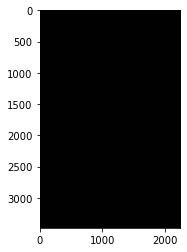

In [20]:
plt.imshow(mySRGAN_hr)

step을 200번만 하니 모델이 제대로 학습을 못해서 검은색 배경만 나타나네요.

STEP을 더 늘려보겠습니다. 

#### SRGAN step 1000번 반복 

위에서 직접 만든 SRGAN 모델을 이용하여 Super Resolution을 하겠습니다.  
**step=1000**

In [20]:
# 학습시킨 생성자 모델을 사용하기위해 저장을 합니다. 
generator.save("my_SRGAN.h5")

In [3]:
# save한 모델을 불러 옵니다.
model_file = "my_SRGAN.h5"
srgan = tf.keras.models.load_model(model_file, compile=False) 

In [17]:
# 위에서 만든 srgan으로 super resolution을 하겠습니다.
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)  # srgan 모델로 image를 생성합니다.
    sr = tf.clip_by_value(sr, 0, 255) # sr 텐서가 0보다 작은경우  0으로, 255보다 큰경우 255로 고정 
    sr = tf.round(sr)  # tensor 값이 소수점인 경우 반올림
    sr = tf.cast(sr, tf.uint8)  # image 값이니 0-255로 한다.
    return np.array(sr)[0]

# 원본이미지로 할 경우 
mySRGAN_hr = apply_srgan(down4_img)

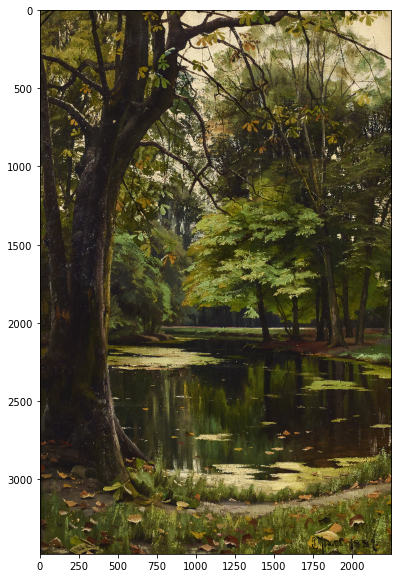

In [21]:
plt.figure(figsize=(16,10))
plt.imshow(mySRGAN_hr)

그럼 세부 이미지로 한번 비교해보곘습니다.

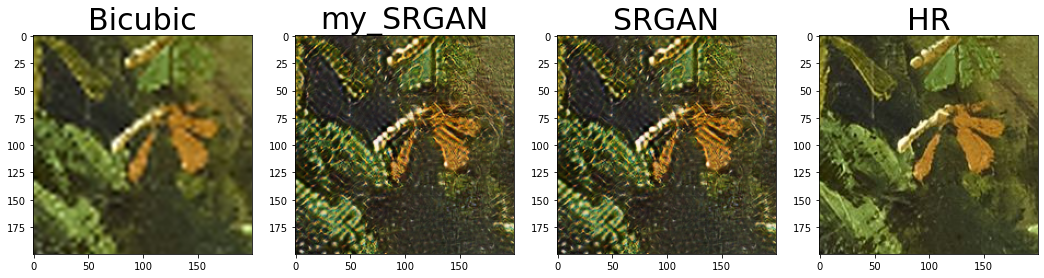

In [23]:
images = []
left_top = [(1500,700)]  # 같은 위치에서의 비교

# 위에서 만든 crop 함수 사용 [ left_top기준 이미지 자름  (200,200) 크기 ]
img1 = crop(bicubic_hr, left_top, 200, 200)
img2 = crop(mySRGAN_hr , left_top, 200, 200)
img3 = crop(srgan_hr , left_top, 200, 200)
img4 = crop(img, left_top, 200, 200)
images.extend([img1, img2, img3, img4])

labels = ["Bicubic", "my_SRGAN" ,"SRGAN", "HR"]

plt.figure(figsize=(18,18))
for i in range(4):
    plt.subplot(1,4,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

모델 학습을 200번 반복만 해서 Generator가 제대로 성능을 발휘하지 못해서 step를 1000번 하게 만들었습니다.

그 결과 위의 미리 학습된 SRGAN과 상당히 흡사한 이미지가 보입니다. 

#### 200번 했을때 loss 값 : 
EPOCH[1] - STEP[200]   
Generator_loss:0.0063   
Discriminator_loss:0.1106  


#### 1000번 했을때의 loss 값 : 
EPOCH[1] - STEP[1000]   
Generator_loss:0.0089   
Discriminator_loss:0.0450  


- 위의 결과를 보고 Super Resolution했을 떄의 이미지를 보면, 더 좋게 나왔을때는 loss값이 전체적으로 0에 수렴할때가 더 좋은 결과가 나왔습니다. 


- 200했을땐 모델이 학습이 제대로 안되고 1000번정도 해야 괜찮은 결과가 나오는것 같습니다.

 ---

## project 1-2.

### 1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.

In [8]:
image_path = os.path.join(os.getenv('HOME'), 'aiffel','super_resolution')
image_path

'/home/ssac27/aiffel/super_resolution'

(400, 533) 크기에 lemon tree 이미지를 가지고 옵니다. 

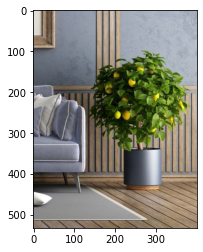

In [5]:
img = image.imread(image_path+'/lemon_tree.jpeg')
plt.imshow(img)
plt.show()

In [6]:
img.shape

(533, 400, 3)

### 2. 불러온 이미지를 입력으로 **SRGAN**을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 **apply_srgan** 함수를 사용하면 쉽습니다.

위에서 사용한 **SRGAN.h5** 모델을 사용하겠습니다.

In [7]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file, compile=False) 
# compile=False를 하지 않을 경우 WARNING이 발생한다. 
# 관련 내용 :
# https://stackoverflow.com/questions/53295570/userwarning-no-training-configuration-found-in-save-file-the-model-was-not-c

In [8]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

srgan_hr = apply_srgan(img)

### 3. 1.에서 불러온 이미지에 **bicubic interpolation**을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. **cv2.resize()**를 사용해 봅시다.

In [9]:
img.shape

(533, 400, 3)

(2132, 1600, 3)


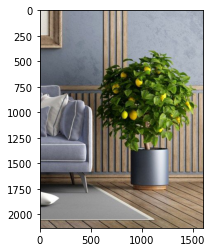

In [10]:
def img_upsample(image, n) :
    upsample = cv2.resize(
        image,
        dsize=(img.shape[1]*n, img.shape[0]*n),   # 원본 이미지의 x,y 크기를 n배로 늘입니다.
        interpolation=cv2.INTER_CUBIC
)
    return upsample
bicubic_hr = img_upsample(img, 4) # 이미지 크기를 4배로 늘립니다.
print(bicubic_hr.shape)
plt.imshow(bicubic_hr)

위의 이미지를 1/4로 downsample한 후 4배로 upsample을 하겠습니다.  
그러고 나서 원본 이미지와 비교해 보겠습니다.

In [11]:
# bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다.
# 이미지를 특정 크기로 줄이고 다시 늘리는 과정을 함수로 정의합니다.
def img_downsample(image, n):
    downsample = cv2.resize(
        image,
        dsize=(image.shape[1]//n, image.shape[0]//n), # dsize() (가로 픽셀 수, 세로 픽셀 수) 
        interpolation=cv2.INTER_CUBIC
    )                 # 세로가 0번, 가로가 1번이다.
    return downsample

down_bicubic_hr = img_downsample(img, 4) # 1/4로 줄이기


# 1/4로 줄인 이미지를 다시 4배로 bicubic interpolation 합니다.
down_up_bicubic_hr = cv2.resize(
    down_bicubic_hr,
    dsize=(down_bicubic_hr.shape[1]*4, down_bicubic_hr.shape[0]*4),   # 원본 이미지의 x,y 크기를 n배로 늘입니다.
    interpolation=cv2.INTER_CUBIC
)



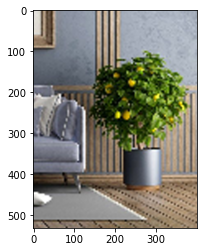

In [12]:
plt.imshow(down_up_bicubic_hr)

### 4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화합니다. 각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.

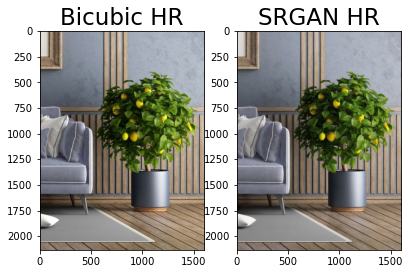

In [15]:
# 타이틀 별 이미지를 가지고 옵니다.
images = [ bicubic_hr, srgan_hr ]
titles = ["Bicubic HR", "SRGAN HR"]

# 이미지 제목을 포함하여 시각화 합니다. 
plt.figure(figsize=(10,6))
for i in range(2):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] , fontsize=23)

이미지 전체를 시각화했을 때는 세부적인 선명함이 눈에 띄지 않기 때문에, 일부 영역을 잘라내어 시각적으로 비교해보겠습니다.  
2개 이미지(bicubic interpolation의 결과, SRGAN의 결과)를 나란히 시각화합니다.

위에서 사용했던 **`crop`** 함수를 사용하겠습니다.

In [17]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

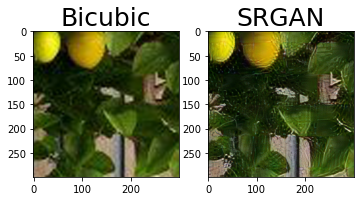

In [19]:
left_tops = [(1000,800)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_hr, left_top, 300, 300)
    img2 = crop(srgan_hr , left_top, 300, 300)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"]

plt.figure(figsize=(12,12))
for i in range(2):
    plt.subplot(1,4,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=25)

SRGAN도 까끌한 느낌이 있지만 Bicubic보다는 좀 더 선명함이 느껴집니다.

선명도 : Bicubic -> SRGAN

### 5. 선택한 이미지를 **DIV2K 데이터셋**에서 학습된 모델로 **Super Resolution**했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

위에선 SRGAN으로 Super Resolution을 했으니 DIV2K 데이터셋을 SRCNN으로 학습시킨 모델을 사용합니다.

In [3]:
import tensorflow as tf

# 데이터를 불러옵니다.
train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)


def preprocessing(lr, hr):
    # 이미지의 크기가 크므로 (96,96,3) 크기로 임의 영역을 잘라내어 사용합니다.
    hr = tf.image.random_crop(hr, size=[96, 96, 3])
    hr = tf.cast(hr, tf.float32) / 255.
    
    # 잘라낸 고해상도 이미지의 가로, 세로 픽셀 수를 1/4배로 줄였다가
    # interpolation을 이용해 다시 원래 크기로 되돌립니다.
    # 이렇게 만든 저해상도 이미지를 입력으로 사용합니다.
    lr = tf.image.resize(hr, [96//4, 96//4], "bicubic")
    lr = tf.image.resize(lr, [96, 96], "bicubic")
    return lr, hr

train = train.map(preprocessing).shuffle(buffer_size=10).batch(16)
valid = valid.map(preprocessing).batch(16)

### SRCNN 구현하기
---

앞서 살펴본 대로 SRCNN은 3개 convolutional layer를 사용한 구조를 가지고 있습니다. 따라서 아래 코드와 같이 Sequential API를 활용해 간단하게 구현할 수 있습니다.

In [4]:
from tensorflow.keras import layers, Sequential

# 3개의 convolutional layer를 갖는 Sequential 모델을 구성합니다.
srcnn = Sequential()
# 9x9 크기의 필터를 128개 사용합니다.
srcnn.add(layers.Conv2D(128, 9, padding="same", input_shape=(None, None, 3)))
srcnn.add(layers.ReLU())
# 5x5 크기의 필터를 64개 사용합니다.
srcnn.add(layers.Conv2D(64, 5, padding="same"))
srcnn.add(layers.ReLU())
# 5x5 크기의 필터를 64개 사용합니다.
srcnn.add(layers.Conv2D(3, 5, padding="same"))

srcnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   31232     
_________________________________________________________________
re_lu (ReLU)                 (None, None, None, 128)   0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    204864    
_________________________________________________________________
re_lu_1 (ReLU)               (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     4803      
Total params: 240,899
Trainable params: 240,899
Non-trainable params: 0
_________________________________________________________________


### SRCNN 학습하기
---
최적화 방법과 손실 함수를 설정하고, 앞서 전처리한 데이터를 이용해 아래와 같이 간단하게 학습할 수 있습니다. 우선 20 epoch만 학습 시켜 봅시다.

In [5]:
srcnn.compile(
    optimizer="adam", 
    loss="mse"
)

srcnn.fit(train, validation_data=valid, epochs=20)

Epoch 1/20
50/50 [==============================] - 17s 336ms/step - loss: 0.0368 - val_loss: 0.0096
Epoch 2/20
50/50 [==============================] - 7s 146ms/step - loss: 0.0072 - val_loss: 0.0055
Epoch 3/20
50/50 [==============================] - 7s 144ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 4/20
50/50 [==============================] - 7s 146ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 5/20
50/50 [==============================] - 7s 148ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 6/20
50/50 [==============================] - 7s 147ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 7/20
50/50 [==============================] - 8s 154ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 8/20
50/50 [==============================] - 7s 149ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 9/20
50/50 [==============================] - 7s 149ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 10/20
50/50 [==============================] - 7s 147ms/step - loss: 0.0048 - val_loss: 0.004

In [ ]:
srcnn.save("my_SRCNN.h5")

In [24]:
model_file = os.getenv('HOME')+'/aiffel/EXPLORATION_/E16_Super_Resolution/my_SRCNN.h5'
srcnn= tf.keras.models.load_model(model_file, compile=False)

In [25]:
def apply_srcnn(image):
    sr = srcnn.predict(image[np.newaxis, ...]/255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr *= 255.
    return np.array(sr[0].astype(np.uint8))

srcnn_hr = apply_srcnn(img)

Bicubic, SRCNN, 원본 이미지 총 3개를 시각화해서 이미지 비교를 하겠습니다.

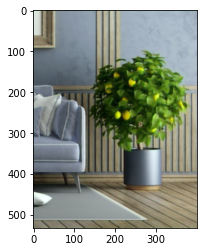

In [26]:
plt.imshow(srcnn_hr)

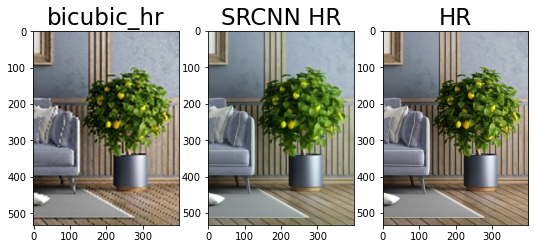

In [28]:
# 타이틀 별 이미지를 가지고 옵니다.
images = [down_up_bicubic_hr, srcnn_hr, img ]
titles = ["bicubic_hr", "SRCNN HR",  "HR"]

# 이미지 제목을 포함하여 시각화 합니다. 
plt.figure(figsize=(12,8))
for i in range(3):
    plt.subplot(1,4,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] , fontsize=23)

이미지 전체를 시각화했을 때는 세부적인 선명함이 눈에 띄지 않기 때문에, 일부 영역을 잘라내어 시각적으로 비교해보겠습니다.  
3개 이미지(bicubic interpolation의 결과, SRCNN의 결과, 원본 이미지)를 나란히 시각화합니다.

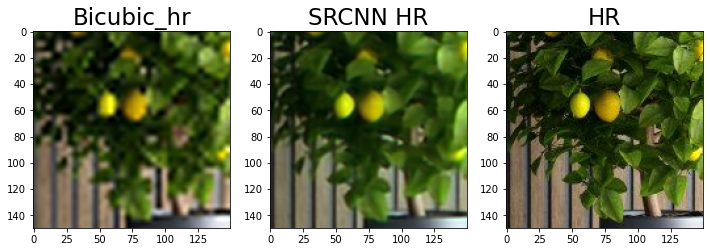

In [112]:
left_top = (200, 150)
crop_images = []

# 타이틀 별 이미지를 가지고 옵니다.
images = [down_up_bicubic_hr, srcnn_hr, img ]
titles = ["Bicubic_hr", "SRCNN HR",  "HR"]



# image의 크기를 left_top기준으로 자르고 리스트에 받습니다.
for idx,image in enumerate(images):
    crop_images.append( crop(image, left_top, 150, 150) )


# 이미지 제목을 포함하여 시각화 합니다. 
plt.figure(figsize=(12,8))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(crop_images[i])
    plt.title(titles[i] , fontsize=23)

3개의 이미지를 세부적으로 보니 bicubic -> SRCNN -> HR 순으로 높은 선명도를 보입니다.

SRCNN은 3개의 Convolitional layer를 사용하는 구조를 가지고 있습니다. 구조를 보면 SRGAN보다 더 얕은 layer 깊이를 가지고 있고 덜 복잡한 구조를 가지고 있습니다.  

위에서 SRGAN으로 crop한 이미지를 봤을때 SRCNN 모델을 사용한 이미지가 덜 선명해 보입니다.  

그렇지만 SRCNN은 딥러닝을 사용하지 않은 Bicubic Interpolation보다 더 선명하게 crop된 것이 보입니다.  


프로젝트를 진행했을때 확인한 Super Resolution image의 선명도 순은 Bicubic -> SRCNN -> SRGAN -> HR 이미지 순으로 확인이 됩니다.

---

### Projecct1-1, 1-2 시각화 비교

1-1에서의 SRGAN의 결과, 1-2에서의 SRGAN 결과를 시각화하여 비교해봅시다. 

1-1은 고해상도 이미지를 **img_downsample()** 함수를 통해 이미지 크기를 줄이고  
1-2는 낮은 해상도를 가진 이미지를 그대로 사용하겠습니다.

In [30]:
pr1_img = image.imread(image_path+'/Autumn_day_in_the_forest_(1889)_ MutualArt.jpeg')
pr1_img.shape

(3483, 2248, 3)

In [33]:
import cv2
# 이미지를 특정 크기로 줄이고 다시 늘리는 과정을 함수로 정의합니다.
def img_downsample(image, n):
    downsample = cv2.resize(
        image,
        dsize=(image.shape[1]//n, image.shape[0]//n), # dsize() (가로 픽셀 수, 세로 픽셀 수) 
        interpolation=cv2.INTER_CUBIC
    )                 # 세로가 0번, 가로가 1번이다.
    return downsample

pr1_down_img = img_downsample(pr1_img, 4) # 1/4로 줄이기

print(pr1_down_img.shape)  # 이미지가 1/4 크기로 줄어들었다. 

(870, 562, 3)


In [32]:
pr2_img = image.imread(image_path+'/lemon_tree.jpeg')
pr2_img.shape

(533, 400, 3)

In [5]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file, compile=False) 
# compile=False를 하지 않을 경우 WARNING이 발생한다. 
# 관련 내용 :
# https://stackoverflow.com/questions/53295570/userwarning-no-training-configuration-found-in-save-file-the-model-was-not-c

In [6]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

In [7]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

#### project_1-1.
높은 해상도를 가진 이미지를 1/4로 픽셀 수 줄인 다음에 SRGAN 진행

In [8]:
pr1_srgan_hr = apply_srgan(pr1_down_img)

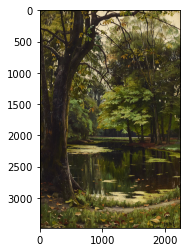

In [9]:
plt.imshow(pr1_srgan_hr)

Text(0.5, 1.0, 'project1-1 SRGAN')

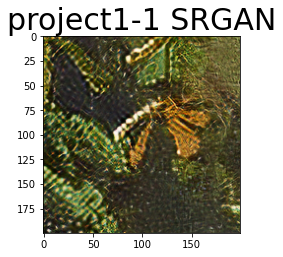

In [11]:
left_top = (1500,700)

image = []
img1 = crop(pr1_srgan_hr, left_top, 200, 200)
image.extend([img1])

labels = "project1-1 SRGAN"

plt.figure(figsize=(12,12))

plt.subplot(1,3,1) 
plt.imshow(image[0])
plt.title(labels, fontsize=30)

#### project_1-2.
낮은 해상도를 가진 이미지를 그대로 사용해서 SRGAN 진행

In [8]:
pr2_srgan_hr = apply_srgan(pr2_img)

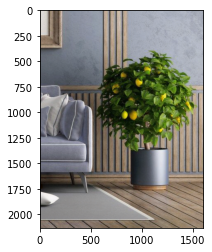

In [9]:
plt.imshow(pr2_srgan_hr)

Text(0.5, 1.0, 'project1-2 SRGAN')

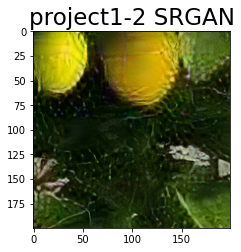

In [20]:
left_top = (1000, 800)
image = []

# 타이틀 별 이미지를 가지고 옵니다.
img = [pr2_srgan_hr]
titles = "project1-2 SRGAN"

img1 = crop(pr2_srgan_hr, left_top, 200, 200)
image.extend([img1])



# 이미지 제목을 포함하여 시각화 합니다. 
plt.figure(figsize=(12,12))

plt.subplot(1,3,1)
plt.imshow(image[0])
plt.title(titles , fontsize=23)

### 두 이미지 시각화 결과 
Project 1-1의 이미지는 그림이고, Project 1-2의 이미지는 사진이여서 세부적으로 봤을때 차이가 있지만, Project 1-2를 자세히 보면 부분 부분 흰색 선 같이 이미지를 오려서 붙인듯한 느낌을 주는 반면에 Project 1-1는 그림으로 이루어진 이미지라는 느낌이 더 자연스럽게 나는것 같습니다.  

위에 결과를 바탕으로 생각해보면 **저해상도 이미지 -> SRGAN(Super Resolution) -> 고해상도 이미지**를 만드는 것보다 **고해상도 이미지 -> Bicubic interppolation (크기 줄이기) -> SRGAN(Super Resolution) -> 고해상도 이미지**로 하는것이 더 자연스럽게 **Super Resolution** 되는것 같습니다.


--- 

## Project 2
<br>


### 1. gif 파일 불러오기
---

아래 주소에 몇 개의 gif 파일이 있습니다. 이 중 하나를 골라 다운 로드하여 아래 과정을 수행합시다. 

#### GIF files
https://drive.google.com/drive/folders/1OLsa4btdwNUiVJcOJgZe_C6-lwEoNr4e

<br>

In [2]:
root_path = os.path.join(os.getenv('HOME'), 'aiffel','super_resolution')
root_path

'/home/ssac27/aiffel/super_resolution'

In [3]:
gif = cv2.VideoCapture(root_path + "/project2_gif/fire_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))


frame 수 : 14
frame 크기 : (282, 300, 3)


### 2. 프레임별 Super Resolution 진행하기
---
Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 3배로 늘려봅시다. Super Resolution이 완료된 각각의 결과를 **frames_bicubic**, **frames_sr**이라는 리스트에 넣어줍니다.

<br>

#### Bicubic interplation
Bicubic interplation으로 이미지의 Super Resolution을 진행합니다.   
픽셀수는 3배의 크기로 만듭니다.

- 4배로 했을때 gif 파일이 너무 커졌으므로 큰 차이가 안나지만 용량은 줄어든 3배로 진행한다.

In [4]:
# bicubic interpolation으로 픽셀수를 n배 증가시킵니다.
def bicubic_interpolation(image,n): 
    bicubic_image = cv2.resize(
        image,
        dsize=(image.shape[1]*n , image.shape[0]*n),
        interpolation=cv2.INTER_CUBIC
    )
    return bicubic_image
    

In [5]:
frames_bicubic = []
for frame in frames: 
    frames_bicubic.append(bicubic_interpolation(frame, 3)) # 각 프레임의 크기 3배로 증가
    
len(frames_bicubic)

14

In [6]:
# 픽셀의 크기가 3배로 늘어났다.
frames_bicubic[0].shape 

(846, 900, 3)

#### SRGAN을
SRGAN을으로 이미지의 Super Resolution을 합니다.  
픽셀수는 4배의 크기로 만듭니다.

In [7]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file, compile=False) 
# compile=False를 하지 않을 경우 WARNING이 발생한다. 

In [8]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

In [9]:
frames_sr = []
for frame in frames:
    frames_sr.append( apply_srgan(frame) )
len(frames_sr)

14

In [10]:
frames_sr[0].shape

(1128, 1200, 3)

### 3. 프레임을 합쳐 gif 만들기
---
위에서 **frame_sr**을 만들었다면 아래 코드와 같이 gif 파일을 생성할 수 있습니다. Bicubic 및 SRGAN의 결과를 각각 저장하여 2개 파일을 만들어 주세요.

In [11]:
import imageio

imageio.mimsave("bicubic_fire.gif", frames_bicubic)
imageio.mimsave("SRGAN_fire.gif", frames_sr)


### 4. Jupyter notebook에 gif 표시하기
---
다운받은 저해상도 gif와 SRGAN으로 생성한 gif를 주피터 노트북내에서 재생해서 비교해보겠습니다.

In [8]:
from IPython.display import Image as show_gif

show_gif("images/fire_lr.gif", width=600) # width 는 적당히 큰 값으로 설정해주세요

<img src="https://github.com/Yongho-Song-dev/Super_Resolution/blob/master/images/fire_lr.gif?raw=true" width="600px">
</img>

In [11]:
show_gif("images/SRGAN_fire.gif", width=600) # 위에서 설정한 width와 같은 값으로 설정해주세요

<img src="https://github.com/Yongho-Song-dev/Super_Resolution/blob/master/images/SRGAN_fire.gif?raw=true" width="600px">
</img>

위에는 원본 gif이미지이고 아래는 SRGAN으로 Super Resolution을 진행했습니다. 
Super Resolution의 결과를 보면 원본은 뿌연 느낌이 들면서 선명하지 못한것 같은 느낌이 드는데 반해 SRGAN은 좀 더 선명한 느낌이 들면서 영상과 같은 느낌이 잘 드러나는것 같습니다. 

---

## 회고

- 영상 편집을 한적이 있고 영상 편집 아르바이트를 한 적이 있어서 이번 프로젝트는 익숙하게 와닿은것 같습니다.  


- 영상 편집을 하다 해상도 크기를 잘못 정하고 랜더링을 한 경우 처음부터 다시 랜더링을 해야해서 해상도 크기를 보통 미리 정해 놓은 상태에서 작업을 시작하는데 여기서 문제는 옛날에 다른 사람이 만들었던 영상의 경우 해상도가 많이 다르기 때문에 이 해상도를 맞추기 위해 원본 Adobe Premiere 프로젝트 파일을 찾아야 합니다. <br> 근데 이 프로젝트 파일을 제대로 정리 안해두시고 떠난 분 같은 경우 이 프로젝트 파일을 찾기는 어렵고 그냥 랜더링이 완료된 파일로 크기를 조정하자니 영상 출력이 이상하게되는 문제가 발생합니다.


- 이 프로젝트를 진행하면서 예전에 프리미어 파일을 찾다 찾다 결국 못찾아서 어쩔 수 없이 조금 떨어지는 화질을 가진 영상을 사용했던게 생각이 나네요.  


- 그리고 요즘 옛날 예능 영상을 요즘 그래픽 화질로 올려서 유튜브에 올리고 있는데 프로젝트를 진행하면서 요즘 그래픽의 옛날 예능 영상들이 계속 생각이 났습니다.  


- 프로젝트의 관련된 문제를 겪어본 적이 있어서 프로젝트가 더 와닿았던 것 같습니다.